## Lab 3: Previsão de Votação de Deputados 

Autora: Lília Sampaio

Neste trabalho faremos uso do framework scikit-learn para desenvolver modelos de predição. Primeiro, importamos as bibliotecas necessárias para fazer uma análise descritiva dos dados e conhecer suas propriedades. 

A atividade usa como inspiração o trabalho desenvolvido em https://www.kaggle.com/apapiu/regularized-linear-models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

### 1. Análise descritiva dos dados

Nesta atividade usaremos os dados referentes às eleições para deputado dos anos de 2006 à 2010 para produzir modelos de predição das próximas eleições. Incialmente usaremos os dados de 2006 como treino, e os 2010 como teste para selecionar o melhor dos modelos e, em seguida, utilizaremos para validação dados referentes às eleições de 2014. Estes dados são carregados abaixo:

In [2]:
train_2006 = pd.read_csv("eleicoes_2006.csv")
test_2010 = pd.read_csv("eleicoes_2010.csv")

Como em qualquer cenário de treino e teste de modelos, precisamos aplicar as mesmas transformações e ações em geral nos dois conjuntos de dados. Para tanto, vamos inicialmente concatenar os dados de 2006 e 2010 para facilitar esse processo e começar a analisá-los e conhecê-los:

In [3]:
all_data_2006_2010 = pd.concat((train_2006, test_2010), sort=False)

Um trecho inicial desse dataset nos mostra a natureza dos dados e as variáveis que encontramos à disposição para serem usadas na predição, entre elas estado e partido do candidato, valor total de sua receita, despesas e recursos recebidos:

In [4]:
all_data_2006_2010.head()

,ano,sequencial_candidato,nome,uf,partido,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,...,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,cargo,sexo,grau,estado_civil,ocupacao,votos
0,2006,10001,JOSÉ LUIZ NOGUEIRA DE SOUSA,AP,PT,6,6,16600.00,2766.666667,NaN,...,14,14,16583.60,1184.542857,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO COMPLETO,CASADO(A),VEREADOR,8579
1,2006,10002,LOIVA DE OLIVEIRA,RO,PT,13,13,22826.00,1755.846154,6625.0,...,24,23,20325.99,883.738696,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,SOLTEIRO(A),SERVIDOR PÚBLICO ESTADUAL,2757
2,2006,10002,MARIA DALVA DE SOUZA FIGUEIREDO,AP,PT,17,16,148120.80,9257.550000,2250.0,...,123,108,146011.70,1351.960185,DEPUTADO FEDERAL,FEMININO,SUPERIOR COMPLETO,VIÚVO(A),PEDAGOGO,17428
3,2006,10002,ROMALDO MILANI,MS,PRONA,6,6,3001.12,500.186667,NaN,...,8,8,3001.12,375.140000,DEPUTADO FEDERAL,MASCULINO,ENSINO MÉDIO INCOMPLETO,CASADO(A),MILITAR REFORMADO,1193
4,2006,10003,ANSELMO DE JESUS ABREU,RO,PT,48,48,NaN,NaN,NaN,...,133,120,116416.64,970.138667,DEPUTADO FEDERAL,MASCULINO,ENSINO FUNDAMENTAL COMPLETO,CASADO(A),DEPUTADO,29401


Uma análise nos valores médios das variáveis, suas medianas, variância e distribuição podem ser vistos abaixo:

In [5]:
all_data_2006_2010.describe()

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7.330000e+03,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,9.179127e+10,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,9.924629e+10,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000100e+04,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,1.056500e+04,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,5.000000e+10,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,1.900000e+11,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,2.700000e+11,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


Ainda podemos ver que o conjunto de dados conta com $7330$ entradas, mas algumas colunas apresentam valores não informados:

In [6]:
all_data_2006_2010.count()

ano                                      7330
sequencial_candidato                     7330
nome                                     7330
uf                                       7330
partido                                  7330
quantidade_doacoes                       7330
quantidade_doadores                      7330
total_receita                            7169
media_receita                            7169
recursos_de_outros_candidatos/comites    4940
recursos_de_pessoas_fisicas              4647
recursos_de_pessoas_juridicas            3354
recursos_proprios                        4942
quantidade_despesas                      7330
quantidade_fornecedores                  7330
total_despesa                            7330
media_despesa                            7330
cargo                                    7330
sexo                                     7330
grau                                     7330
estado_civil                             7330
ocupacao                          

### 2. Análise de distribuição e transformação dos dados

Após conhecer os dados queremos conhecer as variáveis que apresentam algum tipo de viés e realizar as devidas transformações, preencher valores não informados que sejam de interesse e retirar dados que não ajudem nas nossas predições. 

#### 2.1. Lidando com valores não informados

Primeiramente, quando procuramos pelos valores não informados vemos que as colunas referentes aos recursos recebidos possuem várias entradas incompletas, como em ```recursos_de_outros_candidatos/comites```, ```recursos_de_pessoas_fisicas```, ```recursos_de_pessoas_juridicas```, ```recursos_proprios```. Já as colunas de ```total_receita``` e ```media_receita``` possuem poucos valores nessa condição:

In [7]:
all_data_2006_2010.isnull().sum()

ano                                         0
sequencial_candidato                        0
nome                                        0
uf                                          0
partido                                     0
quantidade_doacoes                          0
quantidade_doadores                         0
total_receita                             161
media_receita                             161
recursos_de_outros_candidatos/comites    2390
recursos_de_pessoas_fisicas              2683
recursos_de_pessoas_juridicas            3976
recursos_proprios                        2388
quantidade_despesas                         0
quantidade_fornecedores                     0
total_despesa                               0
media_despesa                               0
cargo                                       0
sexo                                        0
grau                                        0
estado_civil                                0
ocupacao                          

Já que as variáveis referentes ao recebimento de recursos são refletidas na variável ```total_receita```, que não contém tantos dados faltando, vamos desconsiderar tais colunas:

In [8]:
all_data_2006_2010.drop(['recursos_de_outros_candidatos/comites'], axis=1, inplace=True)
all_data_2006_2010.drop(['recursos_de_pessoas_fisicas'], axis=1, inplace=True)
all_data_2006_2010.drop(['recursos_de_pessoas_juridicas'], axis=1, inplace=True)
all_data_2006_2010.drop(['recursos_proprios'], axis=1, inplace=True)

Já para as variáveis de ```total_receita``` e ```media_receita```, decidimos preencher os valores faltantes com a mediana da própria coluna:

In [9]:
all_data_2006_2010['media_receita'].fillna(all_data_2006_2010['media_receita'].median(), inplace = True)
all_data_2006_2010['total_receita'].fillna(all_data_2006_2010['total_receita'].median(), inplace = True)

Se mais uma vez procurarmos por valores faltantes vamos ver que todas as colunas foram preenchidas e as que não eram de interesse foram desconsideradas:

In [10]:
all_data_2006_2010.isnull().sum()

ano                        0
sequencial_candidato       0
nome                       0
uf                         0
partido                    0
quantidade_doacoes         0
quantidade_doadores        0
total_receita              0
media_receita              0
quantidade_despesas        0
quantidade_fornecedores    0
total_despesa              0
media_despesa              0
cargo                      0
sexo                       0
grau                       0
estado_civil               0
ocupacao                   0
votos                      0
dtype: int64

#### 2.2. Desconsiderando variáveis menos interessantes

Algumas das variáveis apresentadas nos dados podem ser desconsideradas na hora de montar o modelo ideal para a sua predição. Aqui decidimos usar apenas as variáveis referentes à receita, despesas e doações para montar a nossa predição. Portanto, todas as demais foram desconsideradas:

In [11]:
all_data_2006_2010.drop(['votos'], axis=1, inplace=True)

In [12]:
all_data_2006_2010.drop(['nome'], axis=1, inplace=True)
all_data_2006_2010.drop(['uf'], axis=1, inplace=True)
all_data_2006_2010.drop(['partido'], axis=1, inplace=True)
all_data_2006_2010.drop(['cargo'], axis=1, inplace=True)
all_data_2006_2010.drop(['grau'], axis=1, inplace=True)
all_data_2006_2010.drop(['estado_civil'], axis=1, inplace=True)
all_data_2006_2010.drop(['ocupacao'], axis=1, inplace=True)
all_data_2006_2010.drop(['sexo'], axis=1, inplace=True)
all_data_2006_2010.drop(['sequencial_candidato'], axis=1, inplace=True)
all_data_2006_2010.drop(['ano'], axis=1, inplace=True)

Agora vemos que estas colunas não aparecem mais no nosso conjunto de dados:

In [13]:
all_data_2006_2010.count()

quantidade_doacoes         7330
quantidade_doadores        7330
total_receita              7330
media_receita              7330
quantidade_despesas        7330
quantidade_fornecedores    7330
total_despesa              7330
media_despesa              7330
dtype: int64

#### 2.3. Distribuição e viés das variáveis

Das variáveis restantes, podemos ver a sua distribuição abaixo:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe244dea470>,
      dtype=object)

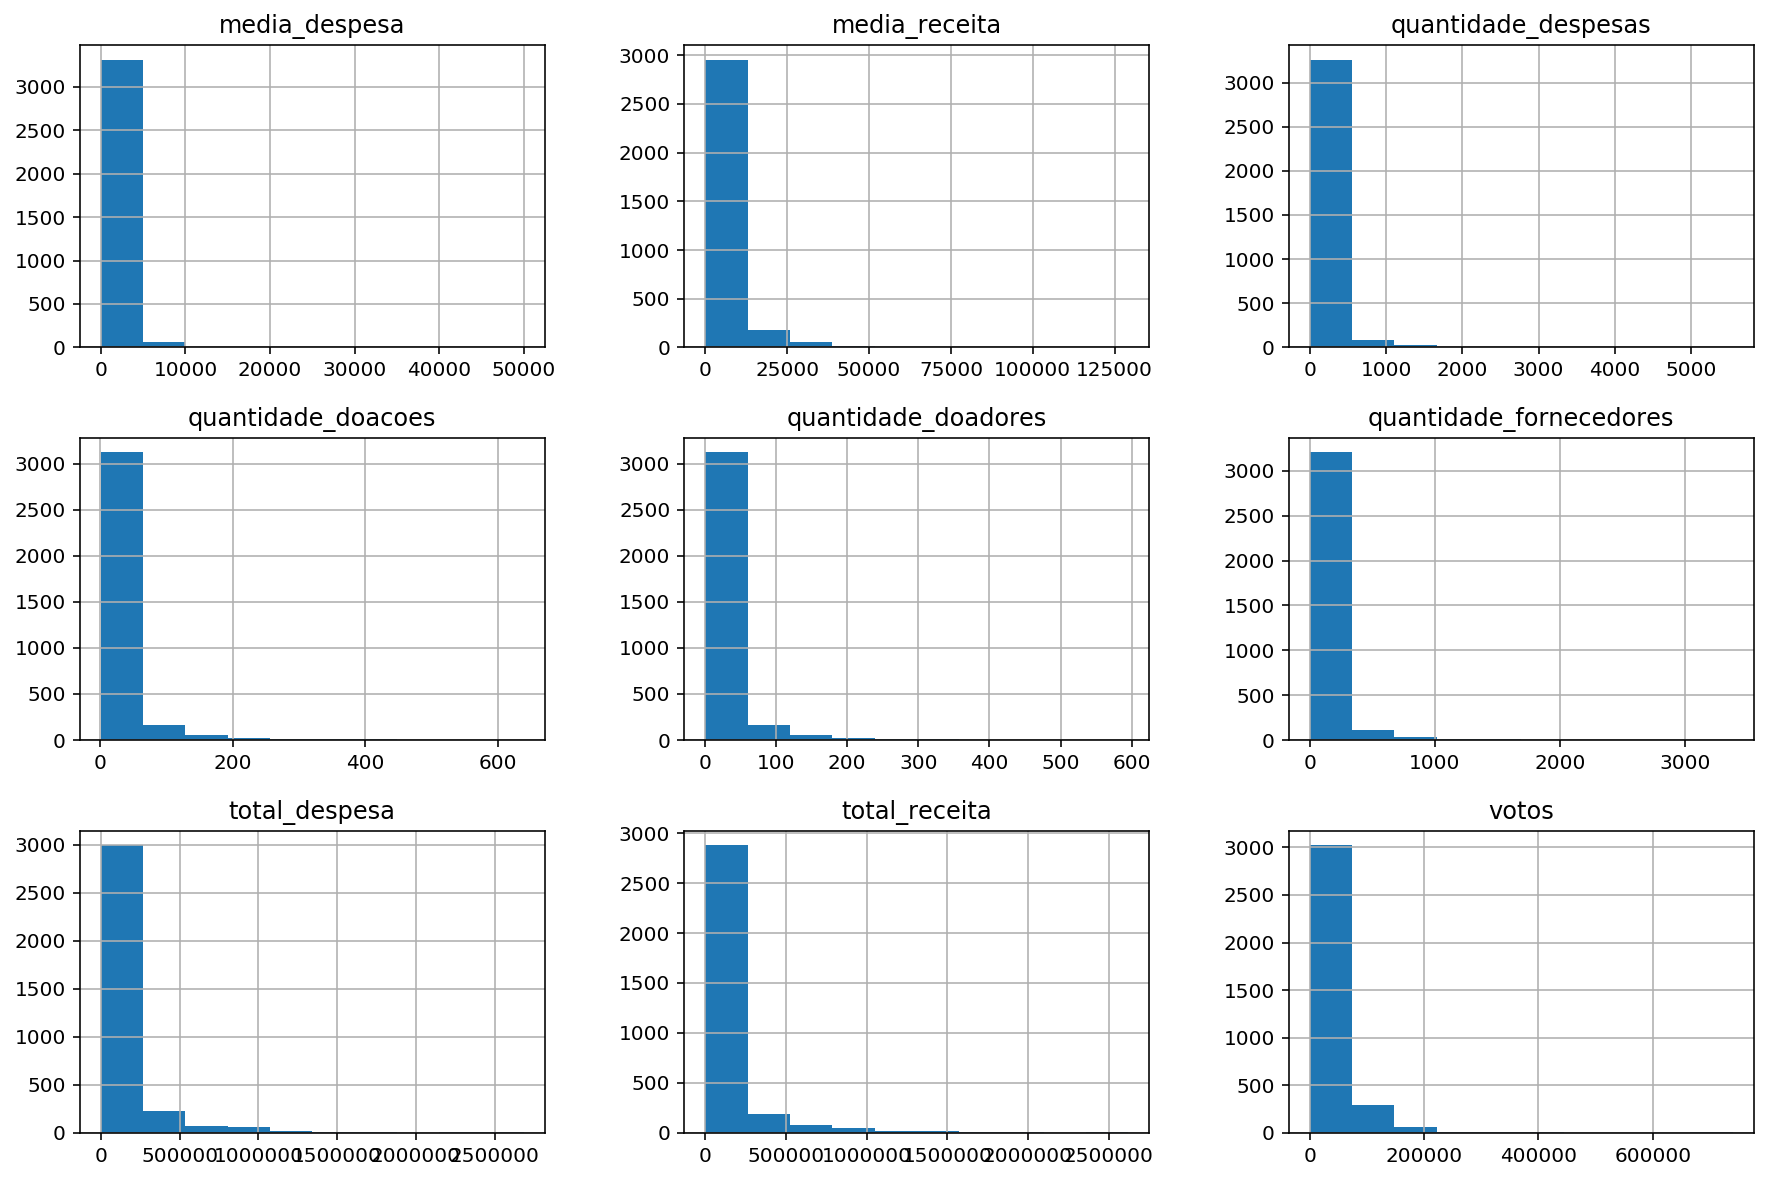

In [14]:
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
skewed_vars = pd.DataFrame({"quantidade_doacoes":train_2006["quantidade_doacoes"], "quantidade_doadores":train_2006["quantidade_doadores"], "total_receita":train_2006["total_receita"], "media_receita":train_2006["media_receita"], "quantidade_despesas":train_2006["quantidade_despesas"], "quantidade_fornecedores":train_2006["quantidade_fornecedores"], "total_despesa":train_2006["total_despesa"], "media_despesa":train_2006["media_despesa"], "votos":train_2006["votos"]})
skewed_vars.hist()

Considerando um viés aceitável de $0.75$, vemos que como mostram as figuras acima e o cálculo abaixo, todas as variáveis apresentam um certo grau de enviesamento, e por isso precisamos corrigi-los através de uma transformação logarítmica:

In [15]:
numeric_feats = all_data_2006_2010.dtypes[all_data_2006_2010.dtypes != "object"].index
skewed_feats = train_2006[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats

quantidade_doacoes          5.466351
quantidade_doadores         5.344165
total_receita               4.540421
media_receita               5.699988
quantidade_despesas         8.061237
quantidade_fornecedores     6.945201
total_despesa               4.354297
media_despesa              10.814488
dtype: float64

In [16]:
all_data_2006_2010["quantidade_doacoes"] = np.log1p(all_data_2006_2010["quantidade_doacoes"])
all_data_2006_2010["quantidade_doadores"] = np.log1p(all_data_2006_2010["quantidade_doadores"])
all_data_2006_2010["total_receita"] = np.log1p(all_data_2006_2010["total_receita"])
all_data_2006_2010["media_receita"] = np.log1p(all_data_2006_2010["media_receita"])
all_data_2006_2010["quantidade_despesas"] = np.log1p(all_data_2006_2010["quantidade_despesas"])
all_data_2006_2010["quantidade_fornecedores"] = np.log1p(all_data_2006_2010["quantidade_fornecedores"])
all_data_2006_2010["total_despesa"] = np.log1p(all_data_2006_2010["total_despesa"])
all_data_2006_2010["media_despesa"] = np.log1p(all_data_2006_2010["media_despesa"])

E agora os dados normalizados são como a seguir:

In [17]:
numeric_feats = all_data_2006_2010.dtypes[all_data_2006_2010.dtypes != "object"].index
normalized_feats = all_data_2006_2010[numeric_feats].apply(lambda x: skew(x.dropna()))
normalized_feats

quantidade_doacoes         0.678789
quantidade_doadores        0.724564
total_receita              0.084830
media_receita              0.148804
quantidade_despesas        0.528203
quantidade_fornecedores    0.551113
total_despesa              0.001469
media_despesa             -0.382036
dtype: float64

### 3. Modelo sem regularização: regressão linear

Vamos gerar um modelo de regressão linear para ver como a predição é realizada quando usamos um modelo sem regularização. Primeiro vamos dividir novamente o conjunto de dados previamente concatenado em treino (2006) e teste (2010), e transformá-los em uma matriz:

In [18]:
matrix_train = all_data_2006_2010[:train_2006.shape[0]]
matrix_test = all_data_2006_2010[train_2006.shape[0]:]
target_train = train_2006.votos
target_test = test_2010.votos

#### 3.1 Calculando RMSE para treino e validação

In [19]:
def calc_train_rmse(X_train, y_train, model):
    predictions = model.predict(X_train)
    mse = mean_squared_error(y_train, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calc_validation_rmse(X_test, y_test, model):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    return rmse
    
def calculate_rmse(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    train_error = calc_train_rmse(X_train, y_train, model)
    validation_error = calc_validation_rmse(X_test, y_test, model)
    return train_error, validation_error

#### 3.2. Modelo de regressão linear e RMSE

Em seguida, introduzimos o modelo calculando o erro implementado acima na função ```calculate_rmse```:

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

linear_regression_model = LinearRegression(fit_intercept=True)

train_error, test_error = calculate_rmse(matrix_train, target_train, matrix_test, target_test, linear_regression_model)
train_error, test_error = round(train_error, 3), round(test_error, 3)

print('train error: {} | test error: {}'.format(train_error, test_error))
print('train/test: {}'.format(round(test_error/train_error, 1)))

train error: 34712.139 | test error: 38351.072
train/test: 1.1


Temos um erro de $34712.139$ no conjunto de treino (2006) e de $38351.072$ (2010). Vamos agora usar modelos com regularização para comparar os resultados.

### 4. Modelos de regressão com regularização

#### 4.1. Modelo Ridge

Calculando ```RMSE``` com cross-validation:

In [21]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model, matrix, target):
    rmse = np.sqrt(-cross_val_score(model, matrix, target, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

Agora vamos calcular o ```RMSE``` para o conjunto de teste e treino usando o modelo Ridge com alphas variando entre ```[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]```:

In [22]:
## Dados de 2006

train_ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv = 5, fit_intercept=True).fit(matrix_train, target_train)
rmse_train_ridge = rmse_cv(train_ridge, matrix_train, target_train).mean()

print('Considerando o treino como os dados de 2006, a média dos RMSE para o modelo Ridge é', rmse_train_ridge)

Considerando o treino como os dados de 2006, a média dos RMSE para o modelo Ridge é 34361.014656438776


In [23]:
## Dados de 2010

test_ridge = RidgeCV(alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv = 5, fit_intercept=True).fit(matrix_test, target_test)
rmse_test_ridge = rmse_cv(test_ridge, matrix_test, target_test).mean()

print('Considerando o teste como os dados de 2010, a média dos RMSE para o modelo Ridge é', rmse_test_ridge)

Considerando o teste como os dados de 2010, a média dos RMSE para o modelo Ridge é 36637.43203093826


#### 4.3. Modelo Lasso

Um próximo modelo a ser considerado é o Lasso. Usando as mesmas bibliotecas anteriores vamos criar o modelo com alphas variando entre ```[1, 0.1, 0.001, 0.0005]```.

Vamos criar modelos para treino e teste, respectivamente, calculando os ```RMSE```:

In [24]:
## Dados de 2006

train_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5, max_iter=10000).fit(matrix_train, target_train)
rmse_train_lasso = rmse_cv(train_lasso, matrix_train, target_train).mean()

print('Considerando o treino como os dados de 2006, a média dos RMSE para o modelo Lasso é', rmse_train_lasso)

Considerando o treino como os dados de 2006, a média dos RMSE para o modelo Lasso é 34359.26778880383


In [25]:
## Dados de 2010

test_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5, max_iter=100000).fit(matrix_test, target_test)
rmse_test_lasso = rmse_cv(test_lasso, matrix_test, target_test).mean()

print('Considerando o treino como os dados de 2006, a média dos RMSE para o modelo Lasso é', rmse_test_lasso)

Considerando o treino como os dados de 2006, a média dos RMSE para o modelo Lasso é 36657.182209815466


Como podemos ver, os resultados de ```RMSE``` para ambos os modelos foram bem similares. Vamos prosseguir com o de menor RMSE para treino: 

In [26]:
min([rmse_train_ridge, rmse_train_lasso])

34359.26778880383

Esse é o valor do ```RMSE``` para o modelo Lasso. Portanto, vamos encontrar seus coeficientes, temos:

In [27]:
coef = pd.Series(train_lasso.coef_, index = matrix_train.columns)

Text(0.5, 1.0, 'Coeficientes no modelo Lasso')

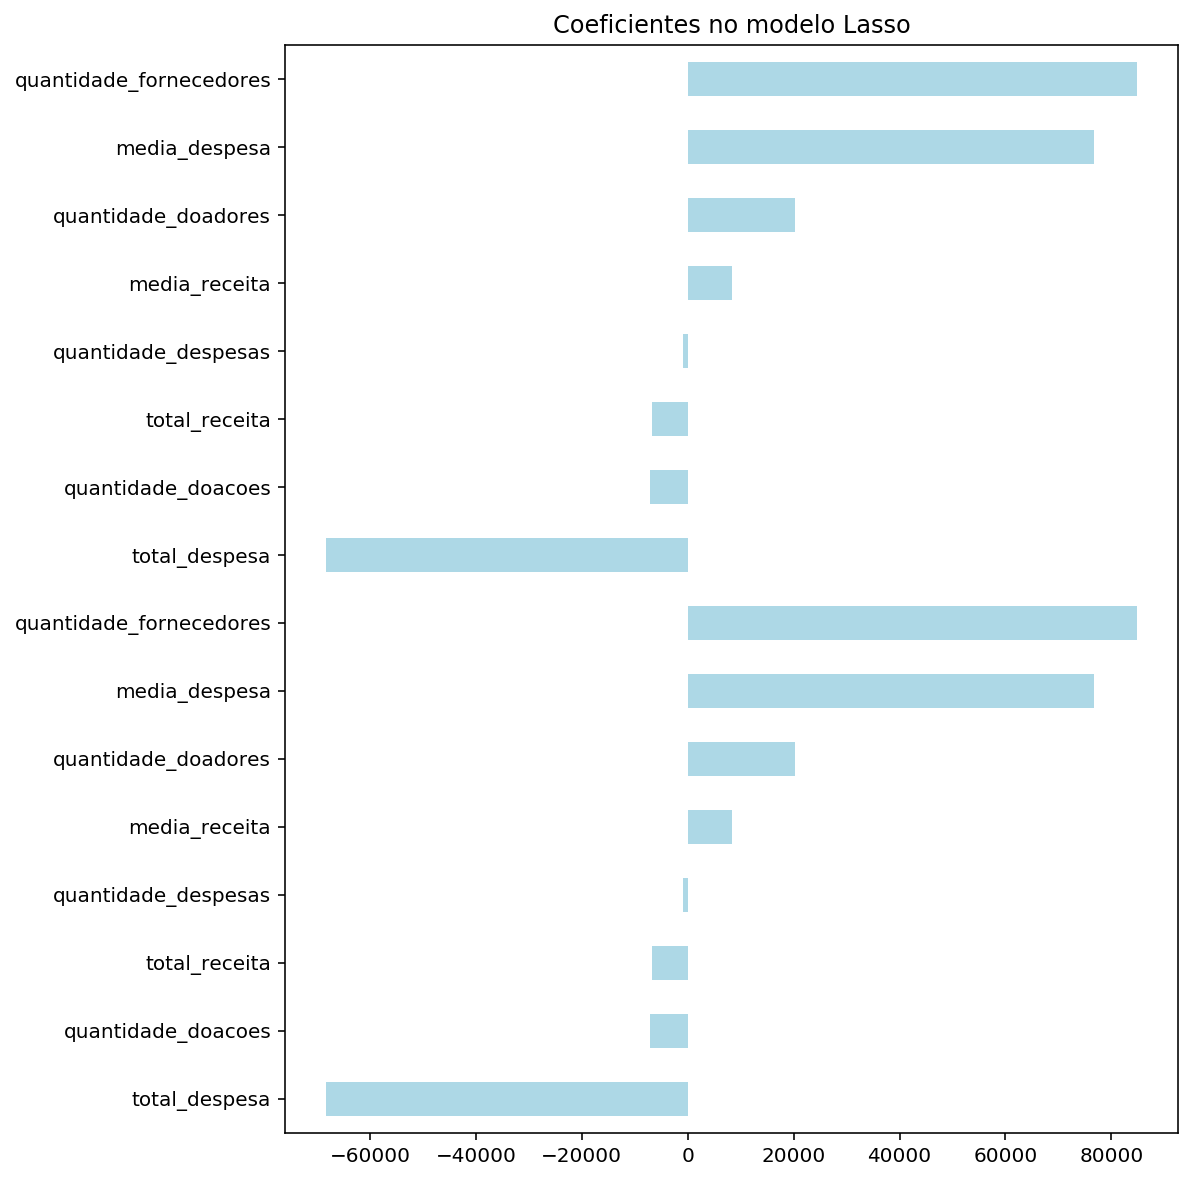

In [28]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh", color = "lightblue")
plt.title("Coeficientes no modelo Lasso")

E agora vendo os resíduos e predições:

* Para os dados de treino:

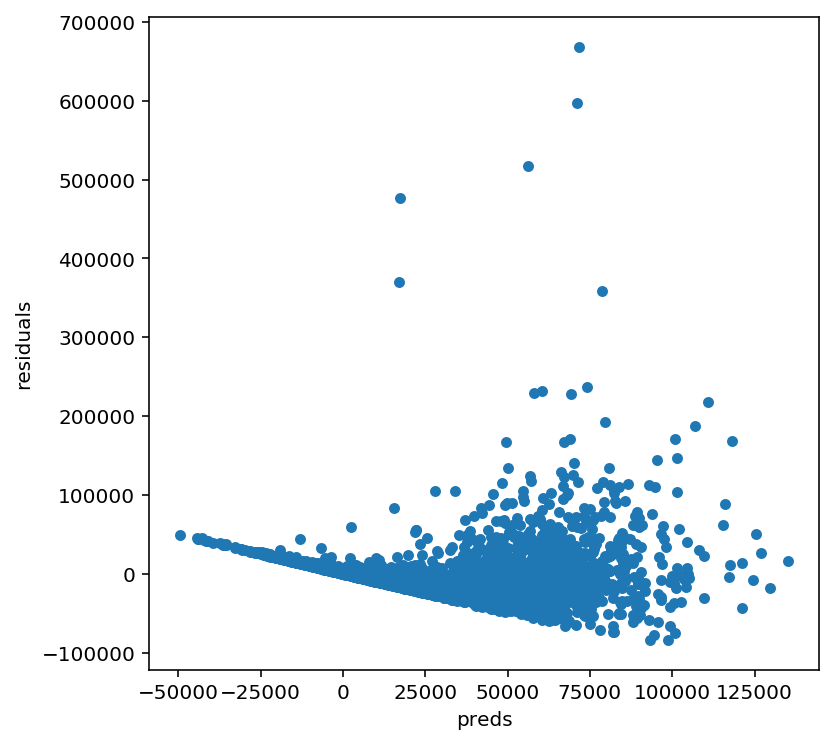

In [29]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":train_lasso.predict(matrix_train), "true":target_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

* Para os dados de teste:

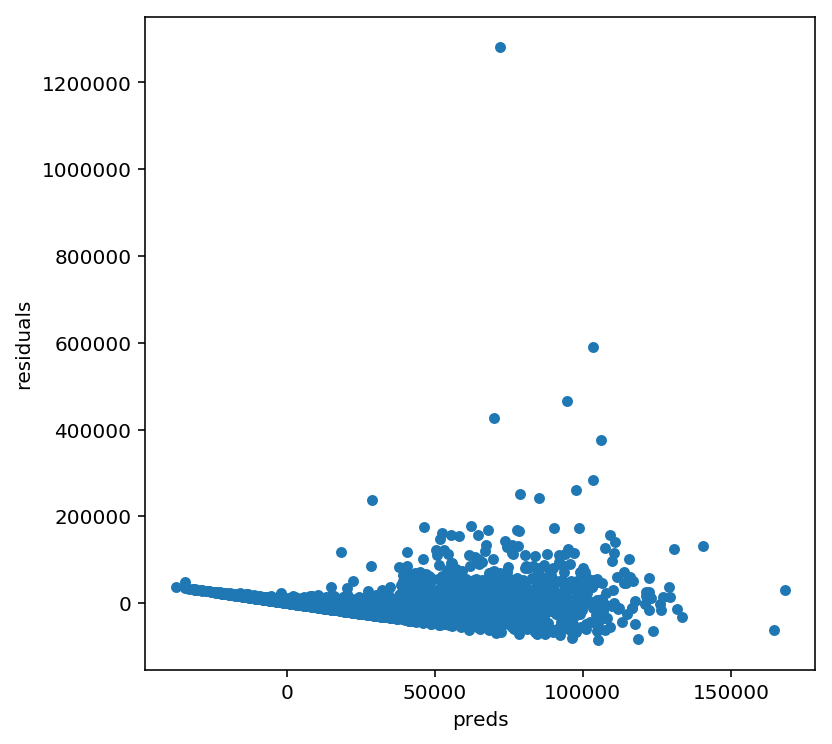

In [30]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":test_lasso.predict(matrix_test), "true":target_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### 5. Modelo de regressão não paramétrico: K-NN

Usando KNN queremos encontrar um valor de K que ache o menor RMSE para as nossas predições. O modelo segue abaixo e retorna o menor RMSE para K variando de $0$ a $100$:

In [31]:
from sklearn.neighbors import KNeighborsRegressor
from math import sqrt

def calculate_knn(matrix, target):
    rmse_val = [] #to store rmse values for different k
    
    for K in range(100):
        K = K+1
        model = KNeighborsRegressor(n_neighbors = K)
        model.fit(matrix, target)  #fit the model

        errors = rmse_cv(model, matrix, target)
        rmse_val.append(errors.mean()) #store rmse values
    
    print('O menor valor de RMSE é', min(rmse_val), 'para K =', rmse_val.index(min(rmse_val)))
    return rmse_val

* Considerando os dados de **treino**, teríamos:

In [32]:
rmse_knn_train = calculate_knn(matrix_train, target_train)

O menor valor de RMSE é 30239.88276513632 para K = 29


O gráfico abaixo confirma o valor de K como sendo $29$ para o menor RMSE nos dados de treino:

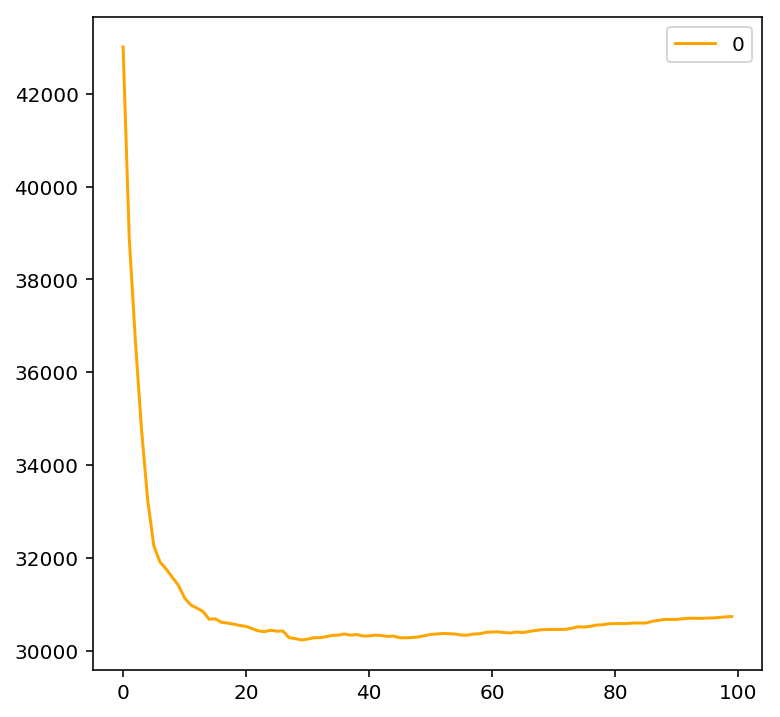

In [33]:
curve_train_knn = pd.DataFrame(rmse_knn_train)
curve_train_knn.plot(color="orange")

* Agora considerando os dados de **teste**, teríamos:

In [34]:
rmse_knn_test = calculate_knn(matrix_test, target_test)

O menor valor de RMSE é 33286.59177036285 para K = 13


O gráfico abaixo confirma o valor de K como sendo $13$ para o menor RMSE:

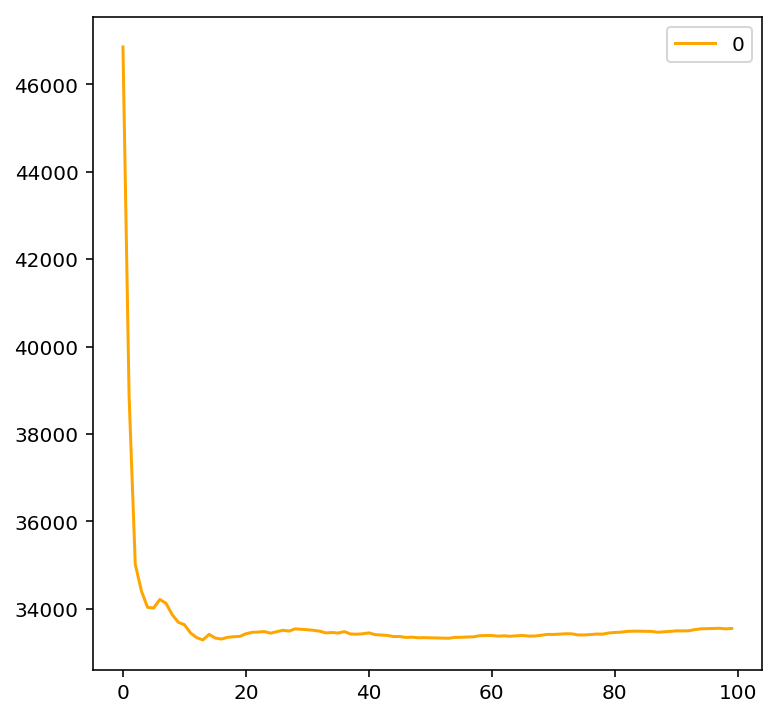

In [35]:
curve_test_knn = pd.DataFrame(rmse_knn_test)
curve_test_knn.plot(color="orange")

* Observando os residuos e predição no modelo de **treino**, temos:

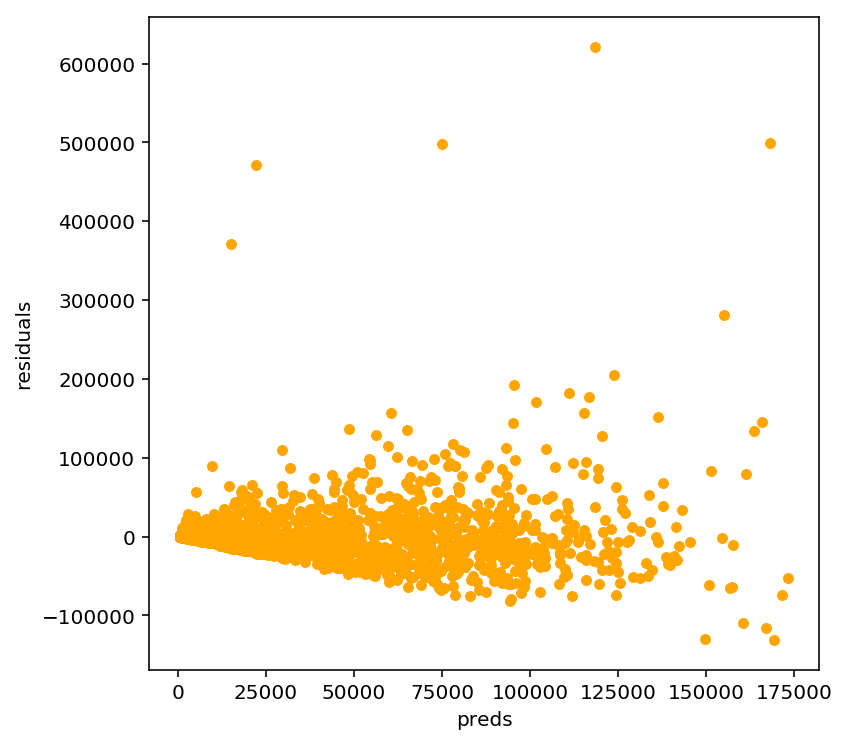

In [36]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

train_knn = KNeighborsRegressor(n_neighbors = 29)
train_knn.fit(matrix_train, target_train)

preds = pd.DataFrame({"preds":train_knn.predict(matrix_train), "true":target_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter",color="orange")

* Observando os residuos e predição no modelo de **teste**, temos:

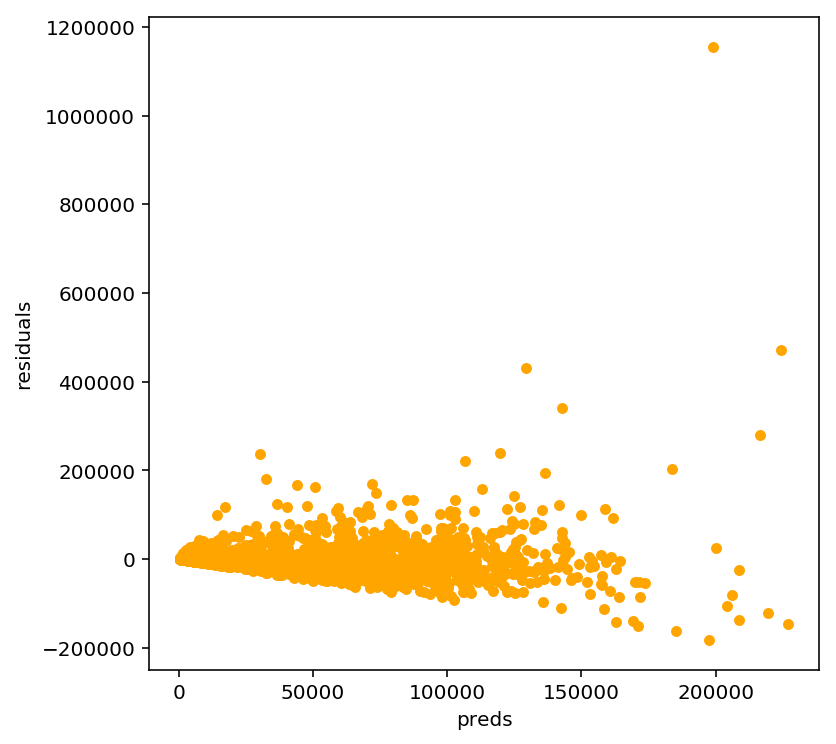

In [37]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

test_knn = KNeighborsRegressor(n_neighbors = 13)
test_knn.fit(matrix_test, target_test)

preds = pd.DataFrame({"preds":test_knn.predict(matrix_test), "true":target_test})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter",color="orange")

### 6. Usando dados de 2014 

Vamos agora retreinar os modelos para os dados de 2006-2010 como sendo treino, e executar o teste com os dados de 2014. 

Primeiro vamos aplicar aos dados de 2014 todas as transformações que aplicamos para 2006 e 2010:

In [38]:
all_data = pd.read_csv("eleicoes_2006_a_2010.csv")
validation_2014 = pd.read_csv("eleicoes_2014.csv")

data_2014 = pd.read_csv("eleicoes_2014.csv")
data_2014.count()

ano                                      4936
sequencial_candidato                     4936
nome                                     4936
uf                                       4936
partido                                  4936
quantidade_doacoes                       4936
quantidade_doadores                      4936
total_receita                            4936
media_receita                            4936
recursos_de_outros_candidatos/comites    3191
recursos_de_pessoas_fisicas              3727
recursos_de_pessoas_juridicas            1714
recursos_proprios                        2860
quantidade_despesas                      4936
quantidade_fornecedores                  4936
total_despesa                            4936
media_despesa                            4936
cargo                                    4936
sexo                                     4936
grau                                     4936
estado_civil                             4936
ocupacao                          

In [39]:
data_2014.drop(['votos'], axis=1, inplace=True)
data_2014.drop(['recursos_de_outros_candidatos/comites'], axis=1, inplace=True)
data_2014.drop(['recursos_de_pessoas_fisicas'], axis=1, inplace=True)
data_2014.drop(['recursos_de_pessoas_juridicas'], axis=1, inplace=True)
data_2014.drop(['recursos_proprios'], axis=1, inplace=True)
data_2014.drop(['nome'], axis=1, inplace=True)
data_2014.drop(['uf'], axis=1, inplace=True)
data_2014.drop(['partido'], axis=1, inplace=True)
data_2014.drop(['cargo'], axis=1, inplace=True)
data_2014.drop(['grau'], axis=1, inplace=True)
data_2014.drop(['estado_civil'], axis=1, inplace=True)
data_2014.drop(['ocupacao'], axis=1, inplace=True)
data_2014.drop(['sexo'], axis=1, inplace=True)
data_2014.drop(['sequencial_candidato'], axis=1, inplace=True)
data_2014.drop(['ano'], axis=1, inplace=True)

In [40]:
numeric_feats = data_2014.dtypes[data_2014.dtypes != "object"].index
skewed_feats = validation_2014[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats

quantidade_doacoes         6.086289
quantidade_doadores        6.286061
total_receita              4.580348
media_receita              5.941006
quantidade_despesas        6.338817
quantidade_fornecedores    6.642770
total_despesa              4.756866
media_despesa              6.858381
dtype: float64

In [41]:
data_2014["quantidade_doacoes"] = np.log1p(data_2014["quantidade_doacoes"])
data_2014["quantidade_doadores"] = np.log1p(data_2014["quantidade_doadores"])
data_2014["total_receita"] = np.log1p(data_2014["total_receita"])
data_2014["media_receita"] = np.log1p(data_2014["media_receita"])
data_2014["quantidade_despesas"] = np.log1p(data_2014["quantidade_despesas"])
data_2014["quantidade_fornecedores"] = np.log1p(data_2014["quantidade_fornecedores"])
data_2014["total_despesa"] = np.log1p(data_2014["total_despesa"])
data_2014["media_despesa"] = np.log1p(data_2014["media_despesa"])

In [42]:
numeric_feats = data_2014.dtypes[data_2014.dtypes != "object"].index
normalized_feats = data_2014[numeric_feats].apply(lambda x: skew(x.dropna()))
normalized_feats

quantidade_doacoes         0.728181
quantidade_doadores        0.740276
total_receita              0.288920
media_receita              0.366149
quantidade_despesas        0.760823
quantidade_fornecedores    0.787169
total_despesa              0.306266
media_despesa             -0.160530
dtype: float64

Por fim, vamos criar as matrizes para esses dados de validação:

In [43]:
matrix_train_all = np.matrix(all_data_2006_2010)
matrix_test_2014 = np.matrix(data_2014)
target_train_all = all_data.votos
target_test_2014 = validation_2014.votos

* O melhor modelo em termos de ```RMSE``` foi o KNN, portanto, vamos retreiná-lo com os dados de treino de 2006 e 2010 e testá-lo com os dados de 2014 para ver se há uma semelhança nos novos valores de erro e predição.

Primeiro para os dados de treino, temos:

In [44]:
rmse_knn_train_all = calculate_knn(matrix_train_all, target_train_all)

O menor valor de RMSE é 33013.53031742484 para K = 65


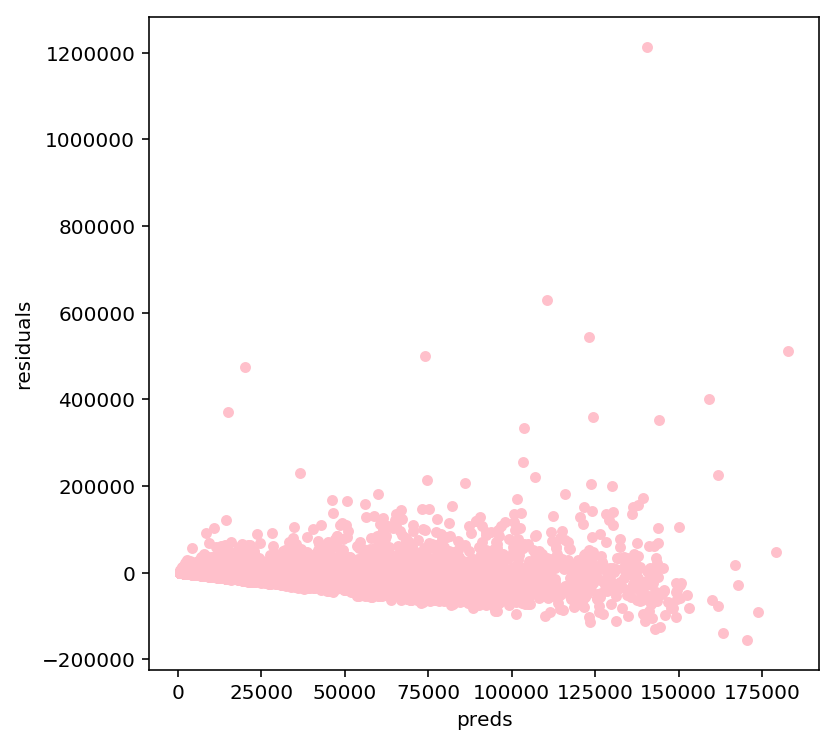

In [45]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

train_knn_all = KNeighborsRegressor(n_neighbors = 29)
train_knn_all.fit(matrix_train_all, target_train_all)

preds = pd.DataFrame({"preds":train_knn_all.predict(matrix_train_all), "true":target_train_all})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter",color="pink")

Agora para o teste:

In [46]:
rmse_knn_test_2014 = calculate_knn(matrix_test_2014, target_test_2014)

O menor valor de RMSE é 31129.289822708717 para K = 85


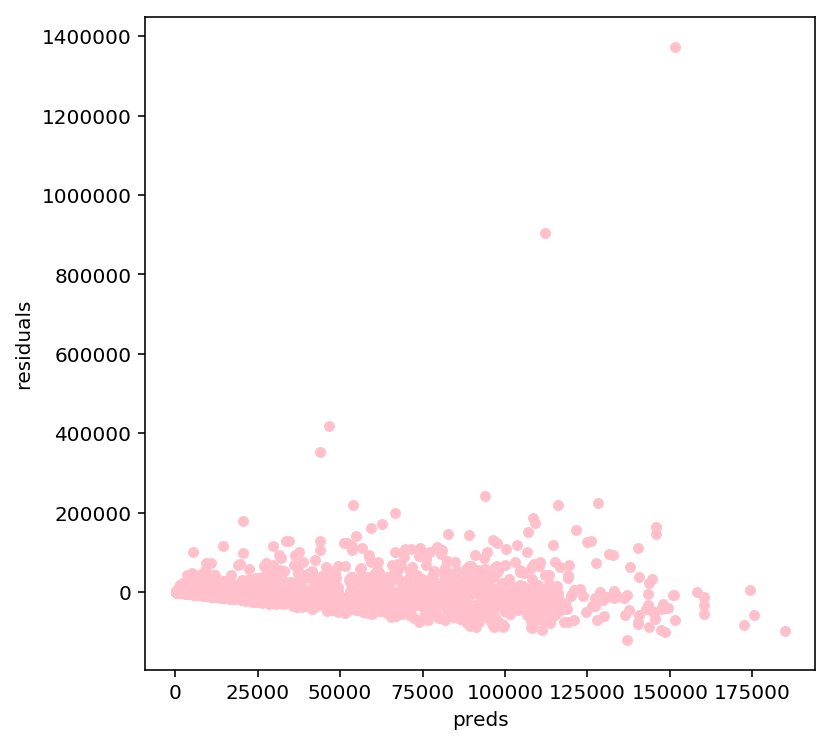

In [47]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

test_knn_2014 = KNeighborsRegressor(n_neighbors = 29)
test_knn_2014.fit(matrix_test_2014, target_test_2014)

preds = pd.DataFrame({"preds":test_knn_2014.predict(matrix_test_2014), "true":target_test_2014})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter",color="pink")

* Olhando para o modelo Lasso, o segundo melhor em termos de ```RMSE```, temos:

In [48]:
train_lasso_all = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5, max_iter=10000).fit(matrix_train_all, target_train_all)
rmse_train_lasso_all = rmse_cv(train_lasso_all, matrix_train_all, target_train_all).mean()

print('Considerando o treino como os dados de 2006 e 2010, a média dos RMSE para o modelo Lasso é', rmse_train_lasso_all)

Considerando o treino como os dados de 2006 e 2010, a média dos RMSE para o modelo Lasso é 36097.24471052254


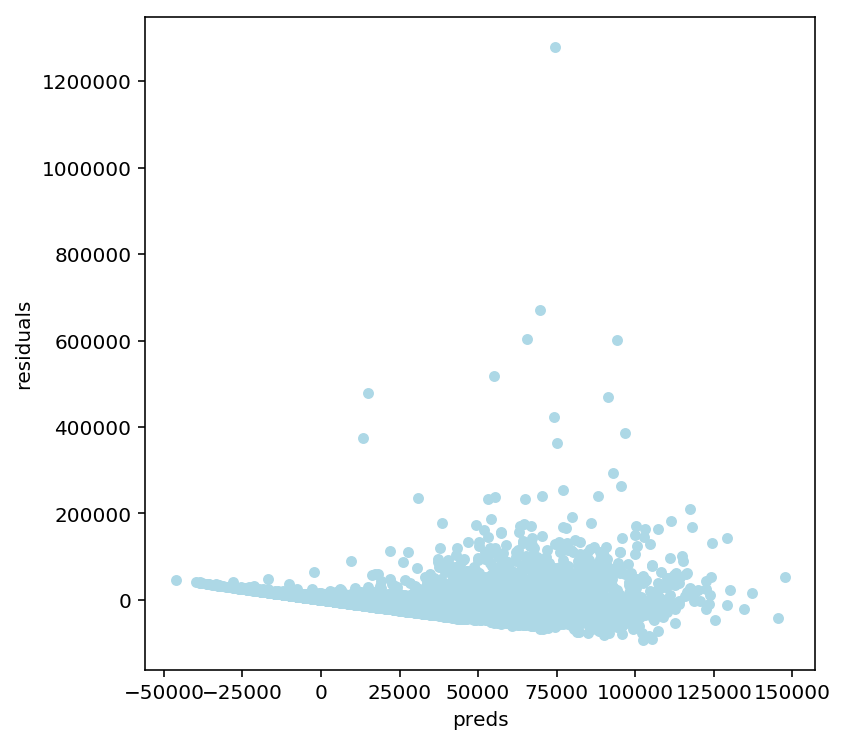

In [49]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":train_lasso_all.predict(matrix_train_all), "true":target_train_all})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter",color="lightblue")

In [50]:
test_lasso_2014 = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], cv=5, max_iter=100000).fit(matrix_test_2014, target_test_2014)
rmse_test_lasso_2014 = rmse_cv(test_lasso_2014, matrix_test_2014, target_test_2014).mean()

print('Considerando o teste como os dados de 2014, a média dos RMSE para o modelo Lasso é', rmse_test_lasso_2014)

Considerando o teste como os dados de 2014, a média dos RMSE para o modelo Lasso é 33823.46610338117


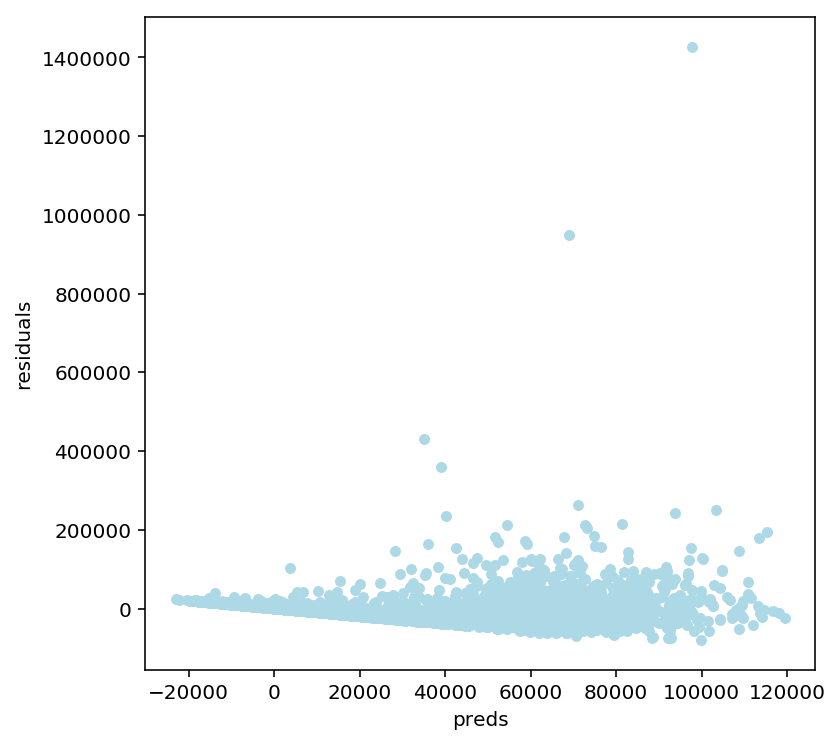

In [51]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":test_lasso_2014.predict(matrix_test_2014), "true":target_test_2014})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter",color="lightblue")